In [6]:
!pip install neural_tangents

     |████████████████████████████████| 125 kB 4.4 MB/s 


In [9]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax import jit, grad, vmap
from jax.config import config
config.update("jax_enable_x64", True)

import urllib.request
dir_data = os.path.join(os.getcwd(),'experiment_data_fixed_train.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-ood-generalization/main/experiment_data_fixed_train.npz"
urllib.request.urlretrieve(url, dir_data)

import functools
import neural_tangents as nt
from neural_tangents import stax

from jax.experimental.ode import odeint

def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
root_dir = "paper_figures/"
ensure_dir(root_dir)

## Define Functions to Compute Theoretical Learning Curves

In [10]:
# take in 
softmax = jit(lambda a: jnp.exp(a) / jnp.exp(a).sum())

@jit
def func(kappa, t, params):
    P, lamb, eigs = params
    return lamb + kappa * jnp.sum( eigs / (eigs * P + kappa) ) - kappa

@jit
def solve_kappa(P, lamb, eigs):
    return odeint(func, lamb, jnp.linspace(0.0,250.0, 25), (P,lamb, eigs))[-1]


@jit
def Eg_wrt_test(a, params):
    eigs, phi0, y, P, lamb = params
    sm = softmax(a)

    O = phi0.T @ jnp.diag(sm) @ phi0

    coeffs = 1/y.shape[0] * phi0.T @ y

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2/(eigs* P + kappa)**2)
    Eg_old = kappa**2/(1-gamma) * jnp.sum(coeffs**2 / (eigs*P + kappa)**2)

    f = jnp.sum(jnp.diag(O) * eigs**2/(eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    G_mid = kappa / (kappa + eigs * P) * coeffs
    Eg = Eg_old * f + jnp.dot(G_mid, (O - f*jnp.eye(O.shape[0])) @ G_mid)

    return Eg

grad_wrt_test = grad(Eg_wrt_test)


@jit
def get_O_tilde_wrt_test(prob, params):
    sm = prob
    eigs, phi0, y, P, lamb = params
    O = phi0.T @ jnp.diag(sm) @ phi0

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2 / (eigs*P + kappa)**2 )
    f = jnp.sum(jnp.diag(O) * eigs**2 / (eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    return O - (1-gamma*f)/(1-gamma)*jnp.eye(O.shape[0])

def kr_expt_measure_test(Pvals, prob_dist, K, y, lamb):
    num_repeat = 35
    errs = np.zeros( (len(Pvals), num_repeat) )
    key = random.PRNGKey(0)
    for n in range(num_repeat):
        for i,P in enumerate(Pvals):
            _, key = random.split(key)
            inds = np.random.choice(K.shape[0], int(P), replace = True)
            Ki = K[inds,:]
            Kii = Ki[:,inds]
            yi = y[inds]
            alpha = np.linalg.solve(Kii+lamb*np.eye(int(P)), yi)
            yhat = Ki.T @ alpha
            errs[i,n] = np.sum(prob_dist * (yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)

def nn_expt_measure_test(Pvals, prob_dist, init_fn, apply_fn, X, y):
    key = random.PRNGKey(0)
    _, params = init_fn(key, (-1, 784))
    
    num_repeat = 5
    errs = np.zeros((len(Pvals), num_repeat))
    
    opt_init, opt_update, get_params = optimizers.adam(5e-2)
    get_params = jit(get_params)
    opt_update = jit(opt_update)
    
    for i,P in enumerate(Pvals):
        print('P = %d'%P)
        for n in range(num_repeat):
            print('Trial %d'%(n + 1))
            opt_state = opt_init(params)
            inds = np.random.choice(K.shape[0], int(P), replace = True)
            loss_fn = jit(lambda params: jnp.mean((apply_fn(params, X[inds]) - y[inds,jnp.newaxis])**2))
            g_loss = jit(grad(loss_fn))
            
            for t in range(500):
                opt_state = opt_update(t, g_loss(get_params(opt_state)), opt_state)
                if t % 250 == 0:
                    print(loss_fn(get_params(opt_state)), np.sum(prob_dist))
                    
            yhat = np.array(apply_fn(get_params(opt_state), X))[:,0]
            errs[i,n] = np.sum(prob_dist * (yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)


def mnist_binary(N_tr, a, b, shuffle = False):
    from tensorflow import keras
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  
    inds_binary_train = [i for i in range(len(y_train)) if y_train[i]==a or y_train[i]==b]
    inds_binary_test = [i for i in range(len(y_test)) if y_test[i]==a or y_test[i]==b]

    if shuffle:
        inds_binary_train = np.random.choice(inds_binary_train, size = N_tr, replace = False)
    else:
        inds_binary_train = inds_binary_train[:N_tr]

    x_train = x_train[inds_binary_train]
    y_train = y_train[inds_binary_train]
    x_train = x_train.reshape(N_tr, x_train.shape[1]*x_train.shape[2])
    x_train = x_train.T - np.mean(x_train, axis = 1)
    x_train = (x_train / np.linalg.norm(x_train, axis = 0)).T

    
    x_test = x_test[inds_binary_test]
    y_test = y_test[inds_binary_test]
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    x_test = x_test.T - np.mean(x_test, axis = 1)
    x_test = (x_test / np.linalg.norm(x_test, axis = 0)).T

    y_train = 1.0*(y_train == a) - 1.0*(y_train == b)
    y_test = 1.0*(y_test == a) - 1.0*(y_test == b)

    return (x_train, y_train), (x_test, y_test)

## Download and Preprocess Data

In [11]:
def fully_connected(width,depth):
    layers = []
    for l in range(depth):
        layers += [stax.Dense(width), stax.Relu()]
    layers += [stax.Dense(1)]
    return stax.serial(*layers)


width=5000
depth = 2
# define a RELU neural tangent kernel
init_fn, apply_fn, kernel_fn = fully_connected(width, depth)
kernel_fn = jit(kernel_fn, static_argnums=(2,))
apply_fn = jit(apply_fn)

# Perform Eigendecomposition to get Eigenvalues and Eigenvectors of the Kernel

### Run This code before optimizing: The kernel is scaled accurately here

In [12]:
a = 9
b = 8
total_pts = 1000
(X, y_vec), (x_test, y_test) = mnist_binary(total_pts, a, b, shuffle = False)

X = jnp.array(X)
y_vec = jnp.array(y_vec)
print(y_vec.shape)

## Compute the Gram Matrix
K = kernel_fn(X, None, 'ntk')


## Compute the eigenvalues and eigenvectors for uniform training distribution.
eig0, phi0 = jnp.linalg.eigh(1/K.shape[0] * K)
phi0 = jnp.sqrt(K.shape[0]) * phi0
eig0 = jnp.abs(eig0)
psi0 =  phi0 @ jnp.diag(jnp.sqrt(eig0))

## Project the target labels on eigenvectors
coeff_phi = 1/K.shape[0] * phi0.T @ y_vec

## Test eigendecomposition
np.square(K- phi0 @ jnp.diag(eig0) @ phi0.T).mean()

11501568/11490434 [==============================] - 0s 0us/step


(1000,)


4.599466824161479e-37

# Optimize Test Measure for Fixed Training Measure

### Uncomment in order to run experiments or skip ahead for precomputed data.

In [13]:
# P_list = [10.0, 30., 50., 100., 500., 10000.]
# epoch_list = [20, 40, 60, 80, 120, 500, 1000]

# ben_dist = []
# adv_dist = []

# lamb = 1e-12
# for epoch in epoch_list:
#     opt_init, opt_update, get_params = optimizers.adam(0.05)
#     all_final_ben = []
#     key = random.PRNGKey(1)
#     for i, P in enumerate(P_list):
#         print('Beneficial | epoch: ', epoch, 'P: ', P)
#         opt_state = opt_init(jnp.zeros(K.shape[0]))
#         params = (eig0, phi0, y_vec, P, lamb)
#         for t in range(epoch):
#             loss = Eg_wrt_test(get_params(opt_state), params)
#             part_ratio = 1.0/(softmax(get_params(opt_state))**2 ).sum()
#             if t % (epoch//3)  == 0:
#                 print("loss %0.5f | participation ratio = %0.5f" % (loss,  part_ratio))
#             g = grad_wrt_test(get_params(opt_state), params)
#             opt_state= opt_update(t, -g, opt_state) # Gradient descent
#         all_final_ben += [get_params(opt_state)]

#     opt_init, opt_update, get_params = optimizers.adam(0.05)
#     all_final_adv = []
#     key = random.PRNGKey(1)
#     for i, P in enumerate(P_list):
#         print('Detrimental | epoch: ', epoch, 'P: ', P)
#         opt_state = opt_init(jnp.zeros(K.shape[0]))
#         params = (eig0, phi0, y_vec, P, lamb)
#         for t in range(epoch):
#             loss = Eg_wrt_test(get_params(opt_state), params)
#             part_ratio = 1.0/(softmax(get_params(opt_state))**2 ).sum()
#             if t % (epoch//3)  == 0:
#                 print("loss %0.5f | participation ratio = %0.5f" % (loss,  part_ratio))
#             g = grad_wrt_test(get_params(opt_state), params)
#             opt_state= opt_update(t, g, opt_state) # Gradient ascent
            
#         all_final_adv += [get_params(opt_state)]
        
        
#     ben_dist += [all_final_ben]
#     adv_dist += [all_final_adv]

In [14]:
# uniform = softmax(jnp.zeros(K.shape[0]))
# Pvals_th = jnp.linspace(1,100,100)
# Pvals_expt = np.linspace(5, 100, 10)

# print('Theory for Uniform')
# theory_uni = jnp.array([Eg_wrt_test(jnp.zeros(y_vec.shape[0]), (eig0, phi0, y_vec, P, lamb)) for P in Pvals_th])
# print('Kernel Regression for Uniform')
# err_uni, std_uni = kr_expt_measure_test(Pvals_expt, uniform, K, y_vec, lamb)
# err_ker_uni = err_uni
# std_ker_uni = std_uni
# print('NN Experiment for Uniform')
# err_uni, std_uni = nn_expt_measure_test(Pvals_expt, uniform, init_fn, apply_fn, X, y_vec)
# err_nn_uni = err_uni
# std_nn_uni = std_uni

# err_ker_ben = []
# std_ker_ben = []
# err_nn_ben = []
# std_nn_ben = []
# theory_ben =[]

# err_ker_adv = []
# std_ker_adv = []
# err_nn_adv = []
# std_nn_adv = []
# theory_adv =[]

# for e_idx in range(len(epoch_list)):
#     theory_ben_P = []
#     theory_adv_P = []
#     err_ker_ben_P = []
#     std_ker_ben_P = []
#     err_ker_adv_P = []
#     std_ker_adv_P = []
#     err_nn_ben_P = []
#     std_nn_ben_P = []
#     err_nn_adv_P = []
#     std_nn_adv_P = []
#     for i, P_idx in enumerate(P_list):
#         print(epoch_list[e_idx])
#         b_dist = ben_dist[e_idx][i]
#         a_dist = adv_dist[e_idx][i]

#         print('Theory for Beneficial')
#         theory_ben_P += [jnp.array([Eg_wrt_test(b_dist, (eig0, phi0, y_vec, P, lamb)) for P in Pvals_th])]
#         print('Kernel Regression for Beneficial')
#         err_ben, std_ben = kr_expt_measure_test(Pvals_expt, softmax(b_dist), K, y_vec, lamb)
#         err_ker_ben_P += [err_ben]
#         std_ker_ben_P += [std_ben]
#         print('NN Experiment for Beneficial')
#         err_ben, std_ben = nn_expt_measure_test(Pvals_expt, softmax(b_dist), init_fn, apply_fn, X, y_vec)
#         err_nn_ben_P += [err_ben]
#         std_nn_ben_P += [std_ben]

#         print('Theory for Detrimental')
#         theory_adv_P += [jnp.array([Eg_wrt_test(a_dist, (eig0, phi0, y_vec, P, lamb)) for P in Pvals_th])]
#         print('Kernel Regression for Detrimental')
#         err_adv, std_adv = kr_expt_measure_test(Pvals_expt, softmax(a_dist), K, y_vec, lamb)
#         err_ker_adv_P += [err_adv]
#         std_ker_adv_P += [std_adv]       
#         print('NN Experiment for Detrimental')
#         err_adv, std_adv = nn_expt_measure_test(Pvals_expt, softmax(a_dist), init_fn, apply_fn, X, y_vec)
#         err_nn_adv_P += [err_adv]
#         std_nn_adv_P += [std_adv]
        
#     theory_ben += [theory_ben_P]
#     theory_adv += [theory_adv_P]
#     err_ker_ben += [err_ker_ben_P]
#     std_ker_ben += [std_ker_ben_P]
#     err_ker_adv += [err_ker_adv_P]
#     std_ker_adv += [std_ker_adv_P]
#     err_nn_ben += [err_nn_ben_P]
#     std_nn_ben += [std_nn_ben_P]
#     err_nn_adv += [err_nn_adv_P]
#     std_nn_adv += [std_nn_adv_P]
    
# np.savez(root_dir + 'data_all_final.npz', 
#          {'epoch_list': np.array(epoch_list), 'P_list': np.array(P_list),
#           'ben_dist': np.array(ben_dist), 'adv_dist': np.array(adv_dist),
#           'Pvals_th': np.array(Pvals_th), 'Pvals_expt': np.array(Pvals_expt), 
#           'err_ker_ben': np.array(err_ker_ben), 'std_ker_ben': np.array(std_ker_ben),
#           'err_ker_adv': np.array(err_ker_adv), 'std_ker_adv': np.array(std_ker_adv),
#           'err_ker_uni': np.array(err_ker_uni), 'std_ker_uni': np.array(std_ker_uni),
#           'err_nn_ben': np.array(err_nn_ben),   'std_nn_ben': np.array(std_nn_ben),
#           'err_nn_adv': np.array(err_nn_adv),   'std_nn_adv': np.array(std_nn_adv),
#           'err_nn_uni': np.array(err_nn_uni),  'std_nn_uni': np.array(std_nn_uni),
#           'theory_ben': np.array(theory_ben), 'theory_adv': np.array(theory_adv), 'theory_uni': np.array(theory_uni)})

## Make test loss worse

In [16]:
data = np.load(dir_data, allow_pickle=True)['arr_0'].tolist()

epoch_list = data['epoch_list']
P_list = data['P_list']
ben_dist = data['ben_dist']
adv_dist = data['adv_dist']
Pvals_th = data['Pvals_th']
Pvals_expt = data['Pvals_expt']

err_ker_ben = data['err_ker_ben']
std_ker_ben = data['std_ker_ben']
err_ker_adv = data['err_ker_adv']
std_ker_adv = data['std_ker_adv']
err_ker_uni = data['err_ker_uni']
std_ker_uni = data['std_ker_uni']

err_nn_ben = data['err_nn_ben']
std_nn_ben = data['std_nn_ben']
err_nn_adv = data['err_nn_adv']
std_nn_adv = data['std_nn_adv']
err_nn_uni = data['err_nn_uni']
std_nn_uni = data['std_nn_uni']

theory_ben = data['theory_ben']
theory_adv = data['theory_adv']
theory_uni = data['theory_uni']

In [17]:
P_list, epoch_list

(array([   10.,    30.,    50.,   100.,   500., 10000.]),
 array([  20,   40,   60,   80,  120,  500, 1000]))

In [18]:
P_idx = 2

idx_ben = jnp.argsort(softmax(ben_dist[0][P_idx]))[::-1]
idx_adv = jnp.argsort(softmax(adv_dist[0][P_idx]))[::-1]

epoch_ben_sort = []
epoch_adv_sort = []
epoch_uni_sort = []
for epoch_ben, epoch_adv in zip(ben_dist, adv_dist):
    epoch_ben_sort += [softmax(epoch_ben[P_idx][idx_ben])]
    epoch_adv_sort += [softmax(epoch_adv[P_idx][idx_ben])]

epoch_ben_sort = np.array(epoch_ben_sort)
epoch_adv_sort = np.array(epoch_adv_sort)


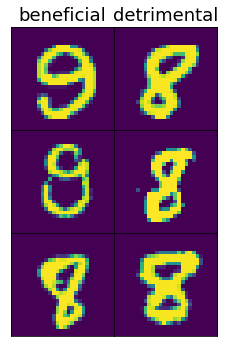

In [19]:
num_samp =3
fig, axs = plt.subplots(num_samp,2,figsize=(3.7,5.7))
axs = axs.T
X_ben = X[idx_ben[:num_samp]].reshape(num_samp,28,28)
X_adv = X[idx_adv[:num_samp]].reshape(num_samp,28,28)

for i, x_ben, x_adv in zip(range(num_samp),X_ben,X_adv):
    axs[0,i].imshow(x_ben)
    axs[1,i].imshow(x_adv)
    axs[1,i].set_xticks([])
    axs[0,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_yticks([])
axs[0,0].set_title('beneficial', fontsize=18)
axs[1,0].set_title('detrimental', fontsize=18)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(root_dir+'ben_adv_samples.png', dpi=200)

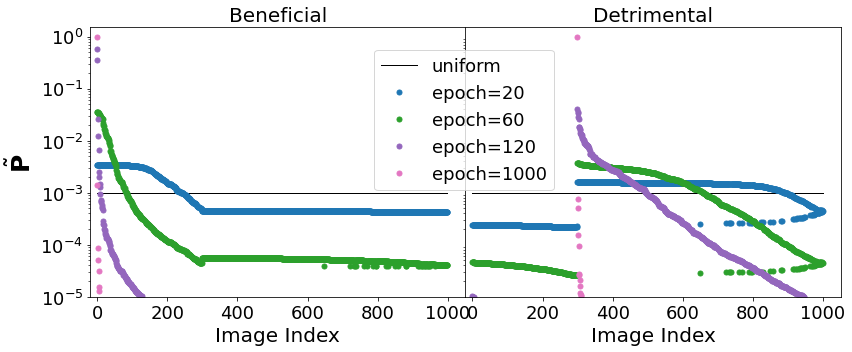

In [20]:
epoch_idx = [0,2,4,6]
fig, axs = plt.subplots(1,2,figsize=(12,5))
for i, ben_sorted,adv_sorted in zip(epoch_idx, epoch_ben_sort[epoch_idx], epoch_adv_sort[epoch_idx]):

    uni_sorted = softmax(jnp.zeros(phi0.shape[0]))
    if i == 0:
        axs[0].plot(uni_sorted, '-',color = 'black', label = 'uniform', linewidth=1)
        axs[1].plot(uni_sorted, '-',color = 'black', label = 'uniform', linewidth=1)
    axs[0].semilogy(ben_sorted*(ben_sorted>1e-5), 'o', label = 'epoch=%d'%epoch_list[i], color='C%d'%i, markersize=5)
    axs[1].semilogy(adv_sorted*(adv_sorted>1e-5), 'o', label = 'epoch=%d'%epoch_list[i], color='C%d'%i, markersize=5, linewidth=2)
    
axs[0].set_title(r'Beneficial',fontsize = 20)
axs[1].set_title(r'Detrimental',fontsize = 20)
axs[0].set_xlabel(r'Image Index',fontsize = 20)
axs[1].set_xlabel(r'Image Index',fontsize = 20)
axs[0].set_ylabel(r'$\tilde\mathbf{P}$',fontsize=25)
axs[0].tick_params(axis='x', labelsize= 18)
axs[1].tick_params(axis='x', labelsize= 18)
axs[0].tick_params(axis='y', labelsize= 18)
axs[1].legend(fontsize = 18, loc='best', bbox_to_anchor=(-0.24, 0.45, 0.5, 0.5))
plt.tight_layout()
axs[1].set_yticks([])    
axs[0].set_xlim([-20, 1050])
axs[1].set_xlim([-20, 1050])
axs[0].set_ylim([1e-5, 1.5])
axs[1].set_ylim([1e-5, 1.5])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(root_dir + 'fixed_train_test_dist.pdf')
plt.show()

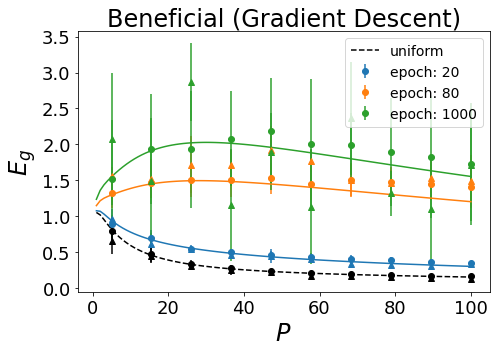

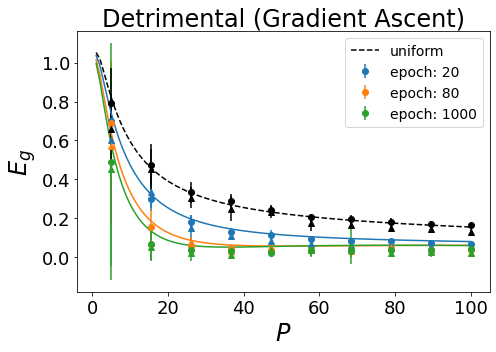

In [21]:
epoch_idx = [0,3,-1]

P_idx =0

err_uni = err_ker_uni
std_uni = std_ker_uni
err_uni_nn = err_nn_uni
std_uni_nn = std_nn_uni
th_uni =  theory_uni

plt.figure(figsize=(7,5))

for i, e_idx in enumerate(epoch_idx):
    th_ben = theory_ben[e_idx][P_idx]
    th_adv = theory_adv[e_idx][P_idx]
    
    err_ben = err_ker_ben[e_idx][P_idx]
    std_ben = std_ker_ben[e_idx][P_idx]
    err_ben_nn = err_nn_ben[e_idx][P_idx]
    std_ben_nn = std_nn_ben[e_idx][P_idx]
    
    err_adv = err_ker_adv[e_idx][P_idx]
    std_adv = std_ker_adv[e_idx][P_idx]
    err_adv_nn = err_nn_adv[e_idx][P_idx]
    std_adv_nn = std_nn_adv[e_idx][P_idx]

    plt.errorbar(Pvals_expt, err_ben, std_ben , fmt='o', color = 'C%d'%i, label='epoch: %d'%epoch_list[e_idx])
    plt.errorbar(Pvals_expt, err_ben_nn, std_ben_nn , fmt='^', color = 'C%d'%i)
    plt.plot(Pvals_th, th_ben, color = 'C%d'%i)
    
plt.errorbar(Pvals_expt, err_uni, std_uni, fmt = 'o', color = 'black')
plt.errorbar(Pvals_expt, err_uni_nn, std_uni_nn , fmt='^', color = 'black')
plt.plot(Pvals_th, th_uni, '--',color = 'black',  label = 'uniform')

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.title('Beneficial (Gradient Descent)', fontsize = 24)
plt.xlabel(r'$P$',fontsize = 24)
plt.ylabel(r'$E_g$',fontsize = 24)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig(root_dir + 'fixed_train_eg_beneficial.pdf')
plt.show()


plt.figure(figsize=(7,5))
for i, e_idx in enumerate(epoch_idx):
    th_ben = theory_ben[e_idx][P_idx]
    th_adv = theory_adv[e_idx][P_idx]
    
    err_ben = err_ker_ben[e_idx][P_idx]
    std_ben = std_ker_ben[e_idx][P_idx]
    err_ben_nn = err_nn_ben[e_idx][P_idx]
    std_ben_nn = std_nn_ben[e_idx][P_idx]
    
    err_adv = err_ker_adv[e_idx][P_idx]
    std_adv = std_ker_adv[e_idx][P_idx]
    err_adv_nn = err_nn_adv[e_idx][P_idx]
    std_adv_nn = std_nn_adv[e_idx][P_idx]

    plt.errorbar(Pvals_expt, err_adv, std_adv , fmt='o', color = 'C%d'%i, label='epoch: %d'%epoch_list[e_idx])
    plt.errorbar(Pvals_expt, err_adv_nn, std_adv_nn , fmt='^', color = 'C%d'%i)
    plt.plot(Pvals_th, th_adv, color = 'C%d'%i)
    
plt.errorbar(Pvals_expt, err_uni, std_uni, fmt = 'o', color = 'black')
plt.errorbar(Pvals_expt, err_uni_nn, std_uni_nn , fmt='^', color = 'black')
plt.plot(Pvals_th, th_uni, '--',color = 'black',  label = 'uniform')

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.title('Detrimental (Gradient Ascent)', fontsize = 24)
plt.xlabel(r'$P$',fontsize = 24)
plt.ylabel(r'$E_g$',fontsize = 24)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig(root_dir + 'fixed_train_eg_detrimental.pdf')
plt.show()